# Cyber Security Threat Detection Using Machine Learning Frameworks

In [1]:
import os
os.chdir('/Users/harshithareddy/Desktop')
filename = 'training_data.csv'

In [2]:
#Importing packages
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Lambda, Input, Dense
from keras.losses import binary_crossentropy

from pandas.plotting import scatter_matrix

from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()  # Remove this line to enable eager execution

import warnings
warnings.filterwarnings('ignore')

from __future__ import print_function

In [3]:
# Create DataFrame
train = pd.read_csv(filename)
train_data = train.copy()
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Columns: 152 entries, 0 to 0.113
dtypes: float64(4), int64(148)
memory usage: 11.6 MB


# Data Preparation

In [4]:
array = train_data.values
X_train = array[:, 0:151]
y_train = array[:, 151]

In [5]:
# Split into a train and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=3)
print(X_train.shape)

(7999, 151)


In [6]:
#Checking train and validation sets still splits across the target evenly
print(y_train.sum())
print(y_valid.sum())

2025.0
501.0


### Normalise Data

In [7]:
norm_scaler = MinMaxScaler(feature_range=(0, 1), clip=True).fit(X_train)
n_X_train = norm_scaler.transform(X_train)
print(n_X_train.shape)

(7999, 151)


In [8]:
n_X_valid = norm_scaler.transform(X_valid)
print(n_X_valid.shape)

(2000, 151)


# Variational Autoencoder

In [9]:
#Variational Autoencoder is used to generate 20 additional features to add to the data set
class Sampling(keras.layers.Layer):
    def call(self, input_data):
        mean, log_var = input_data
        return keras.backend.random_normal(tf.shape(log_var)) * keras.backend.exp(log_var / 2) + mean

input_size = 151
code_size = 20

input_data = Input(shape=(input_size,))
hidden_1 = Dense(75, activation='relu')(input_data)
hidden_2 = Dense(35, activation='relu')(hidden_1)

code_mean = Dense(code_size)(hidden_2)
code_log_var = Dense(code_size)(hidden_2)
code = Sampling()([code_mean, code_log_var])

var_encoder = Model(input_data, outputs=code)

decoder_inputs = Input(shape=[code_size])
hidden_3 = Dense(35, activation='relu')(decoder_inputs)
hidden_4 = Dense(75, activation='relu')(hidden_3)
output_data = Dense(input_size, activation='sigmoid')(hidden_4)

var_decoder = Model(inputs=decoder_inputs, outputs=output_data)

code_input = Input(shape=(code_size,))
reconst = var_decoder(code_input)
var_ae = Model(inputs=code_input, outputs=reconst)

In [10]:
# Custom loss function for Variational Autoencoder
def losses_func(input_data, reconst):
    code_mean = var_encoder(input_data)
    code_log_var = var_encoder(input_data)
    latent_loss = -0.5 * tf.reduce_sum(1 + code_log_var - tf.exp(code_log_var) - tf.square(code_mean), axis=-1)
    reconstruction_loss = tf.keras.losses.binary_crossentropy(input_data, reconst)
    return (tf.reduce_mean(latent_loss) / 151.) + reconstruction_loss

var_ae.compile(optimizer='adam', loss=losses_func)

# Enabling eager execution
tf.config.run_functions_eagerly(True)

# Encode input data using the encoder model
encoded_train_data = var_encoder.predict(n_X_train)
encoded_valid_data = var_encoder.predict(n_X_valid)

# Train the Variational Autoencoder with the encoded features
history = var_ae.fit(x=encoded_train_data, y=n_X_train, epochs=10, validation_data=(encoded_valid_data, n_X_valid))

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.4278 - val_loss: 0.2203
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2195 - val_loss: 0.2185
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2187 - val_loss: 0.2189
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2178 - val_loss: 0.2182
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2171 - val_loss: 0.2178
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2182 - val_loss: 0.2185
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2166 - val_loss: 0.2172
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2175 - val_loss: 0.2182
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2165 - val_loss: 0.2174
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2171 - val_loss: 0.2184


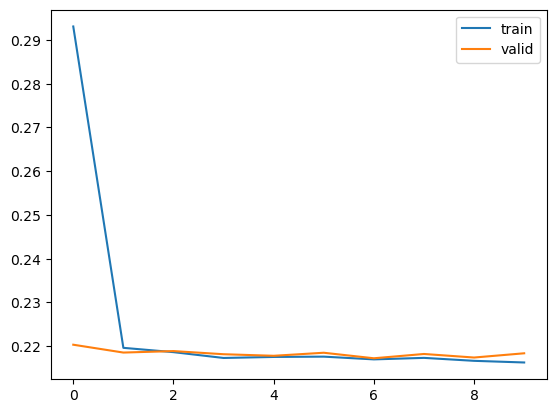

In [11]:
pyplot.plot(history.history['loss'],label = 'train')
pyplot.plot(history.history['val_loss'], label = 'valid')
pyplot.legend()
pyplot.show()  

In [12]:
#The trained variational encoder contains the reduced features from the code layer
encoded = var_encoder
gen_feat = encoded.predict(n_X_train)
print(gen_feat.shape)

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(7999, 20)


In [13]:
#Statistics of the generated output features
gen_featdf = pd.DataFrame(gen_feat)
gen_featdf.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000
mean,-0.107821,0.059815,-0.219665,-0.319733,-0.119102,-0.313062,-0.031009,-0.070710,-0.113722,0.367438,-0.284125,-0.094279,-0.061017,-0.089214,0.042968,0.123931,-0.110684,0.078395,-0.014277,0.152982
std,0.898034,0.941260,1.052106,0.887875,1.004175,0.973388,1.121887,1.079120,0.961167,0.951190,0.807501,0.986188,0.996780,0.956644,0.937483,0.954074,0.956905,0.858974,1.021786,0.929297
min,-3.934684,-3.558395,-4.143043,-3.919900,-3.922538,-4.120022,-4.176746,-3.965786,-3.738247,-2.960273,-3.020466,-4.180503,-3.785631,-3.865340,-4.064365,-3.256660,-4.121238,-3.189448,-3.821375,-3.519311
25%,-0.706135,-0.574213,-0.935171,-0.914917,-0.791643,-0.968013,-0.778310,-0.784582,-0.761488,-0.274218,-0.832788,-0.775216,-0.739868,-0.741544,-0.581766,-0.511594,-0.734304,-0.493803,-0.711276,-0.462384
50%,-0.106198,0.064199,-0.206606,-0.321407,-0.112482,-0.302024,-0.035743,-0.091341,-0.113489,0.364365,-0.279123,-0.073169,-0.061442,-0.086913,0.041418,0.121823,-0.105621,0.077601,-0.013663,0.158734
75%,0.492326,0.697319,0.503529,0.282287,0.564639,0.338017,0.717544,0.658348,0.532199,1.008017,0.265919,0.564591,0.605425,0.546242,0.671597,0.760786,0.538842,0.662128,0.664874,0.778439
max,3.024395,3.832714,3.598398,2.777524,3.627430,3.099487,4.346183,3.761550,3.362160,4.197637,2.463130,3.569836,3.843743,3.909922,3.571596,4.054212,3.426740,3.318450,4.065542,3.642588


The Variational Encoder code layer, the generated features have a mean of 0 and a standard deviation of 1

In [14]:
#Normalising the generated features and creating a dataframe with new column labels
norm_scaler20 = MinMaxScaler(feature_range = (0,1), clip = True).fit(gen_feat)
n_gen_feat = norm_scaler20.transform(gen_feat)
n_gen_feat = pd.DataFrame(n_gen_feat)
new_col_headers = map(str,[160,161,162,163,164,165,166,167,168,169, 170,171,172,173,174,175,176,177,178,179])
n_gen_feat.columns= new_col_headers

In [15]:
#Adding generated features dataframe to original features dataframe
num_data = open('column_names.csv') #Column names
num_lst = []
for label in num_data:
    label = label.rstrip()
    num_lst.append(label)

n_orig_feat = pd.DataFrame(n_X_train, columns = num_lst)
n_all_feat = pd.concat([n_orig_feat,n_gen_feat],axis = 1)
print(n_all_feat.shape)

(7999, 171)


# Feature Selection

### Variance Threshold Filter

In [16]:
feat_sel = VarianceThreshold()
feat_sel.fit_transform(n_all_feat)
red_feat = pd.DataFrame(feat_sel.transform(n_all_feat))
col_lst = n_all_feat.columns[feat_sel.get_support()]
print(col_lst)
print(len(col_lst))

Index(['frame.time_delta', 'frame.time_delta_displayed', 'frame.len',
       'frame.cap_len', 'frame.marked', 'frame.ignored',
       'radiotap.present.flags', 'radiotap.present.rate',
       'radiotap.present.channel', 'radiotap.present.dbm_antsignal',
       'radiotap.present.lock_quality', 'radiotap.present.db_antnoise',
       'radiotap.present.mcs', 'radiotap.flags.preamble',
       'radiotap.flags.badfcs', 'radiotap.channel.type.turbo',
       'radiotap.channel.type.cck', 'radiotap.channel.type.2ghz',
       'radiotap.channel.type.5ghz', 'radiotap.channel.type.passive',
       'radiotap.rxflags.badplcp', 'wlan.fc.type_subtype', 'wlan.fc.ds',
       'wlan.fc.frag', 'wlan.fc.moredata', 'wlan.fc.protected',
       'wlan.fc.order', 'wlan.duration', 'wlan.ta', 'wlan.ba.control.multitid',
       'wlan_mgt.fixed.capabilities.cfpoll.ap',
       'wlan_mgt.fixed.capabilities.privacy',
       'wlan_mgt.fixed.capabilities.agility',
       'wlan_mgt.fixed.capabilities.spec_man',
       'wlan_

In [17]:
red_feat.columns = col_lst
red_feat.shape

(7999, 69)

### Kbest with Chi2 Filter

In [18]:
kbest = SelectKBest(score_func = chi2, k =30)
kbest_out = kbest.fit_transform(red_feat, y_train)
kbest_out = red_feat.columns[kbest.get_support()]
print(kbest_out)

Index(['frame.time_delta', 'frame.cap_len', 'frame.marked', 'frame.ignored',
       'radiotap.channel.type.turbo', 'radiotap.channel.type.2ghz',
       'radiotap.channel.type.5ghz', 'radiotap.rxflags.badplcp', 'wlan.fc.ds',
       'wlan.fc.frag', 'wlan.fc.moredata', 'wlan.fc.protected',
       'wlan.duration', 'wlan.ba.control.multitid',
       'wlan_mgt.fixed.capabilities.privacy',
       'wlan_mgt.fixed.capabilities.agility',
       'wlan_mgt.fixed.capabilities.spec_man',
       'wlan_mgt.fixed.capabilities.dsss_ofdm', 'wlan_mgt.fixed.auth.alg',
       'wlan_mgt.tim.dtim_count', 'wlan_mgt.tim.bmapctl.multicast',
       'wlan_mgt.tim.bmapctl.offset', 'wlan_mgt.country_info.environment',
       'wlan_mgt.rsn.akms.count', 'wlan_mgt.rsn.akms.type',
       'wlan_mgt.rsn.capabilities.preauth',
       'wlan_mgt.rsn.capabilities.no_pairwise',
       'wlan_mgt.rsn.capabilities.ptksa_replay_counter', 'wlan.qos.priority',
       'wlan.qos.eosp'],
      dtype='object')


In [19]:
red_feat2 = pd.DataFrame(kbest.transform(red_feat))
red_feat2.columns = kbest_out
red_feat2.shape

(7999, 30)

### Kbest with MI Filter

In [20]:
kbest_mi = SelectKBest(score_func = mutual_info_classif, k = 15)
kbest_mi_out = kbest_mi.fit_transform(red_feat2 , y_train)
kbest_mi_out = red_feat2.columns[kbest_mi.get_support()]
print(kbest_mi_out)

Index(['frame.marked', 'frame.ignored', 'radiotap.channel.type.turbo',
       'radiotap.channel.type.2ghz', 'radiotap.channel.type.5ghz',
       'wlan.fc.ds', 'wlan.duration', 'wlan_mgt.fixed.capabilities.privacy',
       'wlan_mgt.fixed.capabilities.dsss_ofdm', 'wlan_mgt.fixed.auth.alg',
       'wlan_mgt.tim.dtim_count', 'wlan_mgt.tim.bmapctl.multicast',
       'wlan_mgt.country_info.environment', 'wlan.qos.priority',
       'wlan.qos.eosp'],
      dtype='object')


In [21]:
X_train_final = pd.DataFrame(kbest_mi.transform(red_feat2))
X_train_final.columns = kbest_mi_out
X_train_final.shape

(7999, 15)

In [22]:
def pairwise_corr(df, threshold = 0.9):
    
    matrix = df.corr()
    mask = np.triu(np.ones_like(matrix,dtype = bool))
    reduced_matrix = matrix.mask(mask)
    col_to_drop = [col for col in reduced_matrix.columns if any (reduced_matrix[col] > threshold)]
    return col_to_drop

corr_columns = pairwise_corr(X_train_final, 0.95)
X_train_corr = X_train_final.drop(corr_columns, axis = 1)
print(X_train_corr.shape)

(7999, 9)


In [23]:
#print columns
print(corr_columns)

['frame.marked', 'wlan_mgt.fixed.capabilities.privacy', 'wlan_mgt.fixed.capabilities.dsss_ofdm', 'wlan_mgt.fixed.auth.alg', 'wlan_mgt.tim.dtim_count', 'wlan.qos.priority']


# Selecting Algorithms

### Exploration of Possible Algorithms

In [24]:
#Comparing algorithms
array = X_train_final.values
X = array[ : , 0:15]
Y = y_train

#Model preparation
models = []
models.append(('LR', LogisticRegression(solver='liblinear')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NB', GaussianNB()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('ET', ExtraTreesClassifier(random_state = 3)))
models.append(('LSVC', LinearSVC(random_state = 3)))
#Evaluating each model 
results = []
names = []
scoring = 'accuracy'
for name, model in models:
  kfold = KFold(n_splits=10, random_state=3,shuffle=True)
  cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

LR: 0.994375 (0.002577)
LDA: 0.994375 (0.002577)
NB: 0.966371 (0.006058)
KNN: 0.999250 (0.000830)
ET: 0.999875 (0.000375)
LSVC: 0.994375 (0.002577)


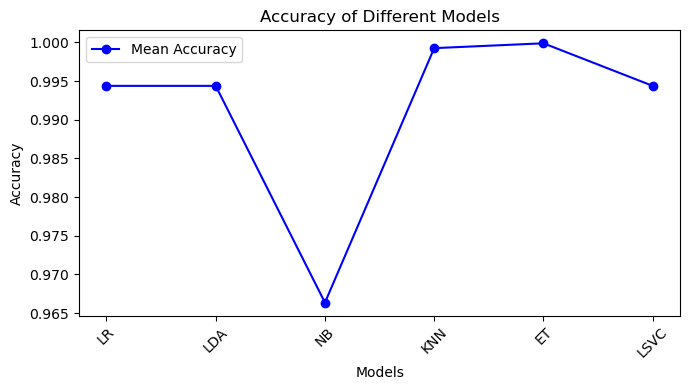

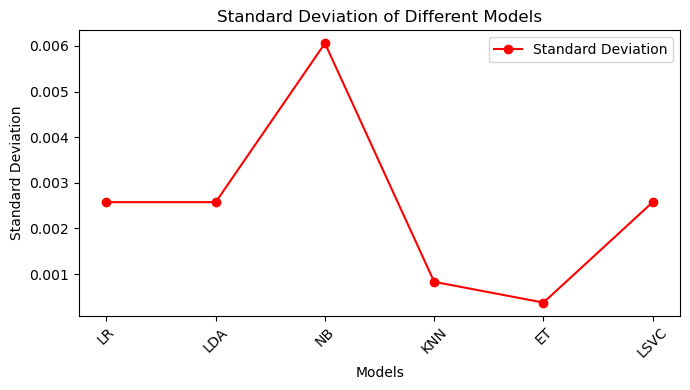

In [25]:
# Plotting cv_results.mean()
pyplot.figure(figsize=(7, 4))
pyplot.plot(names, [cv_results.mean() for cv_results in results], marker='o', linestyle='-', color='b', label='Mean Accuracy')
pyplot.title('Accuracy of Different Models')
pyplot.xlabel('Models')
pyplot.ylabel('Accuracy')
pyplot.xticks(rotation=45)
pyplot.legend()
pyplot.tight_layout()
pyplot.show()

# Plotting cv_results.std()
pyplot.figure(figsize=(7, 4))
pyplot.plot(names, [cv_results.std() for cv_results in results], marker='o', linestyle='-', color='r', label='Standard Deviation')
pyplot.title('Standard Deviation of Different Models')
pyplot.xlabel('Models')
pyplot.ylabel('Standard Deviation')
pyplot.xticks(rotation=45)
pyplot.legend()
pyplot.tight_layout()
pyplot.show()

**Notes on results:**

LR - performs well and trains quickly, assuming linearity  ***FURTHER TUNING DONE BELOW***

LDA/QDA - trains quickly due to dimensionality reduction, performs moderately  ***FURTHER TUNING DONE BELOW***

KNN - performs well but takes more time to run  ***FURTHER TUNING DONE BELOW***

Extra trees - performs too well, likely overfitting, wont peform well on test data. 

NB - simple and performs well, good candidate algorithm  ***FURTHER TUNING DONE BELOW***

Linear SVC - perfoms well since it uses gradient descent and a linear function to reduce the training time, quicker than ET ***FURTHER TUNING DONE BELOW***

## Hyperparameter Tuning

### Logistic Regression Tuning

In [26]:
# Parameters available for LR are: penalty, C, solver
param_grid_lr = [
    {'solver':['lbfgs','liblinear','sag','saga','newton-cg'],'C': [0.01,0.05,0.08,0.1,0.3,0.5,0.8]},
    {'penalty': ['l1'],'solver':['liblinear','saga'],'C': [0.01,0.05,0.08,0.1,0.3,0.5,0.8]},
    {'penalty': ['none'],'solver':['lbfgs','sag','saga','newton-cg'],'C': [0.01,0.05,0.08,0.1,0.3,0.5,0.8]},
]

lr_model = LogisticRegression()
lr_search = RandomizedSearchCV(lr_model, param_grid_lr ,random_state = 2, cv = 5)
lr_search.fit(X_train_final, y_train)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(),
                   param_distributions=[{'C': [0.01, 0.05, 0.08, 0.1, 0.3, 0.5,
                                               0.8],
                                         'solver': ['lbfgs', 'liblinear', 'sag',
                                                    'saga', 'newton-cg']},
                                        {'C': [0.01, 0.05, 0.08, 0.1, 0.3, 0.5,
                                               0.8],
                                         'penalty': ['l1'],
                                         'solver': ['liblinear', 'saga']},
                                        {'C': [0.01, 0.05, 0.08, 0.1, 0.3, 0.5,
                                               0.8],
                                         'penalty': ['none'],
                                         'solver': ['lbfgs', 'sag', 'saga',
                                                    'newton-cg']}],
                   random_state=2)

#### Best results for logistic regression:

In [27]:
lr_search.best_params_

{'solver': 'newton-cg', 'penalty': 'none', 'C': 0.8}

In [28]:
lr_search.best_estimator_

LogisticRegression(C=0.8, penalty='none', solver='newton-cg')

In [29]:
lr_search.best_score_

0.9961244527829894

The above score is an improvement on the initial exploration of models above

### NB Tuning

In [30]:
param_grid_nb = [
    {'var_smoothing': [1e-10,1e-9,1e-7,1e-5]},
    ]

nb_model = GaussianNB()

nb_search = RandomizedSearchCV(nb_model,param_grid_nb,random_state =3, cv=5)
nb_search.fit(X_train_final, y_train)

RandomizedSearchCV(cv=5, estimator=GaussianNB(),
                   param_distributions=[{'var_smoothing': [1e-10, 1e-09, 1e-07,
                                                           1e-05]}],
                   random_state=3)

In [31]:
nb_search.best_params_

{'var_smoothing': 1e-05}

In [32]:
nb_search.best_estimator_

GaussianNB(var_smoothing=1e-05)

In [33]:
nb_search.best_score_

0.9709960913070669

The above score is small improvement on the untuned model

### LSVC Tuning

In [34]:
param_grid_lsvc = [
    {'penalty': ['l1','l2'], 
     'loss': ['sqaured_hinge','hinge'], 
     'C':[0.1,0.3,0.5,0.8,1.0,1.2,1.5,2.0]},
    ]

lsvc_model = LinearSVC(random_state = 3)

lsvc_search = RandomizedSearchCV(lsvc_model,param_grid_lsvc,random_state =3, cv=5)
lsvc_search.fit(X_train_final, y_train)

RandomizedSearchCV(cv=5, estimator=LinearSVC(random_state=3),
                   param_distributions=[{'C': [0.1, 0.3, 0.5, 0.8, 1.0, 1.2,
                                               1.5, 2.0],
                                         'loss': ['sqaured_hinge', 'hinge'],
                                         'penalty': ['l1', 'l2']}],
                   random_state=3)

In [35]:
lsvc_search.best_params_

{'penalty': 'l2', 'loss': 'hinge', 'C': 1.5}

In [36]:
lsvc_search.best_estimator_

LinearSVC(C=1.5, loss='hinge', random_state=3)

In [37]:
lsvc_search.best_score_

0.9943746091307067

The above score is small improvement on the untuned model

### KNN Tuning

In [38]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]  # for Manhattan and Euclidean distance
}

# Initializing the KNN model
knn_model = KNeighborsClassifier()

knn_search = RandomizedSearchCV(knn_model, param_distributions=param_grid_knn, n_iter=20, random_state=2, cv=5)
knn_search.fit(X_train_final, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=20,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'n_neighbors': [3, 5, 7, 9, 11],
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   random_state=2)

In [39]:
knn_search.best_params_

{'weights': 'distance', 'p': 1, 'n_neighbors': 5, 'algorithm': 'ball_tree'}

In [40]:
knn_search.best_estimator_

KNeighborsClassifier(algorithm='ball_tree', p=1, weights='distance')

In [41]:
knn_search.best_score_

0.9994996873045654

The above score is small improvement on the untuned model

### LDA Tuning

In [42]:
param_grid_lda = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': ['auto', None],
    'tol': [1e-4, 1e-3, 1e-2]
}

# Initializing the LDA model
lda_model = LinearDiscriminantAnalysis()

lda_search = RandomizedSearchCV(lda_model, param_distributions=param_grid_lda, n_iter=20, random_state=2, cv=5)
lda_search.fit(X_train_final, y_train)

RandomizedSearchCV(cv=5, estimator=LinearDiscriminantAnalysis(), n_iter=20,
                   param_distributions={'shrinkage': ['auto', None],
                                        'solver': ['svd', 'lsqr', 'eigen'],
                                        'tol': [0.0001, 0.001, 0.01]},
                   random_state=2)

In [43]:
lda_search.best_params_

{'tol': 0.0001, 'solver': 'lsqr', 'shrinkage': 'auto'}

In [44]:
lda_search.best_estimator_

LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')

In [45]:
lda_search.best_score_

0.9943746091307067

The above score has not improved from the untuned model results 

## 5 Models Tuning Summary

In [46]:
# Comparing 5 models with tuned parameters

array = X_train_final.values
X = array[ : , 0:15]
Y = y_train

# Preparing models with best parameters output
models3 = []
models3.append(('LR', lr_search.best_estimator_))
models3.append(('NB', nb_search.best_estimator_))
models3.append(('LSVC', lsvc_search.best_estimator_))
models3.append(('KNN', knn_search.best_estimator_))
models3.append(('LDA', lda_search.best_estimator_))

# Evaluating each model after tuning
results = []
names = []
scoring = 'accuracy'
for name, model in models3:
  kfold = KFold(n_splits=10, random_state=3,shuffle=True)
  cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

LR: 0.997875 (0.001256)
NB: 0.970747 (0.004844)
LSVC: 0.994375 (0.002577)
KNN: 0.999875 (0.000375)
LDA: 0.994375 (0.002577)


# Reviewing the 5 Models using Evaluation Metrics on Validation Data

In [47]:
X_valid = encoded.predict(n_X_valid)
X_valid = norm_scaler20.transform(X_valid)

#Adding 20 features from encoder output to normalised full dataset
X_valid_full = pd.DataFrame(n_X_valid)
X_valid_gen = pd.DataFrame(X_valid)
X_valid_df = pd.concat([X_valid_full,X_valid_gen],axis = 1)

#Feature selection 1 - variance threshold
X_valid = feat_sel.transform(X_valid_df)

#Feature selection 2 - Kbest with chi2 Filter
X_valid = kbest.transform(X_valid)

#Feature selection 2 - Kbest with MI Filter
X_valid = kbest_mi.transform(X_valid)

X_valid.shape

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


(2000, 15)

In [48]:
# Validation target class
y_valid.shape

(2000,)

### Logistic Regression Further Evaluation

In [49]:
#Create Cross-validation scoring function
def scoring_cv(measure, model, X = X, Y = Y):
    kfold = KFold(n_splits = 5, random_state = 2, shuffle = True)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=measure)
    return measure, round(cv_results.mean(),5), round(cv_results.std(),5)

In [50]:
print(scoring_cv('accuracy',lr_search.best_estimator_))
print(scoring_cv('neg_log_loss',lr_search.best_estimator_))
print(scoring_cv('roc_auc',lr_search.best_estimator_))

('accuracy', 0.99787, 0.00102)
('neg_log_loss', -0.0082, 0.00271)
('roc_auc', 0.99994, 3e-05)


AUC: 1.000


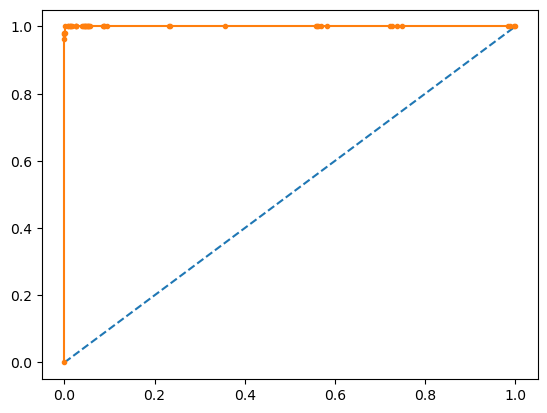

In [51]:
# Fit the model 
lr_model = lr_search.best_estimator_
lr_model.fit(X,Y)
# predict probabilities
probs = lr_model.predict_proba(X_valid)
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_valid, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_valid, probs)
# plot the roc curve for the model
pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot(fpr, tpr, marker='.')
pyplot.show()

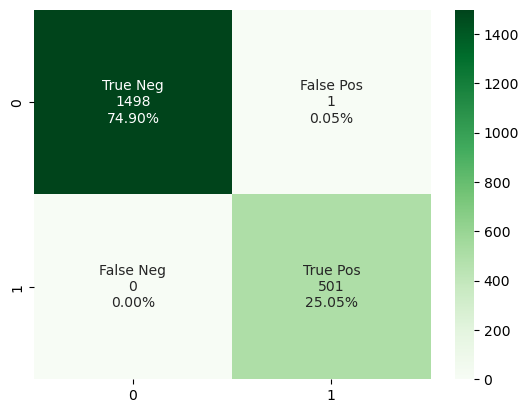

In [52]:
lr_predicted = lr_model.predict(X_valid)
lr_matrix = confusion_matrix(y_valid, lr_predicted)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in lr_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in lr_matrix.flatten()/np.sum(lr_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

#assert len(labels) == np.prod(lr_matrix.shape), "Number of labels must match size of confusion matrix"

# Reshape labels to match the shape of confusion matrix
labels = np.asarray(labels).reshape(lr_matrix.shape)

# Plot the heatmap
sns.heatmap(lr_matrix, annot=labels, fmt='', cmap='Greens')
pyplot.show()

In [53]:
#classification report
lr_report = classification_report(y_valid, lr_predicted) 
print(lr_report)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1499
         1.0       1.00      1.00      1.00       501

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



### Naive Bayes Further Evaluation

In [54]:
print(scoring_cv('accuracy',nb_search.best_estimator_))
print(scoring_cv('neg_log_loss',nb_search.best_estimator_))
print(scoring_cv('roc_auc',nb_search.best_estimator_))

('accuracy', 0.9705, 0.00423)
('neg_log_loss', -0.30983, 0.01852)
('roc_auc', 0.99914, 0.00036)


AUC: 0.999


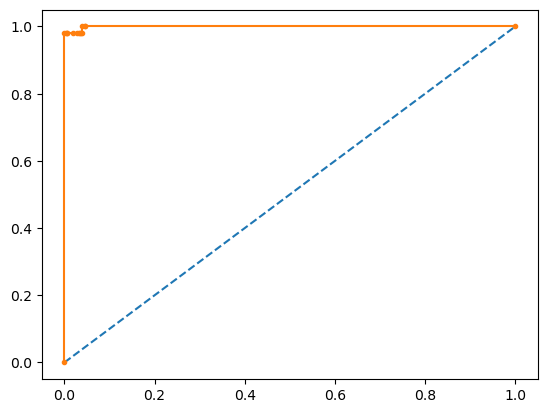

In [55]:
# Fit the model
nb_model = nb_search.best_estimator_
nb_model.fit(X,Y)
# predict probabilities
probs = nb_model.predict_proba(X_valid)
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_valid, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_valid, probs)
# plot the roc curve for the model
pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot(fpr, tpr, marker='.')
pyplot.show()

<Axes: >

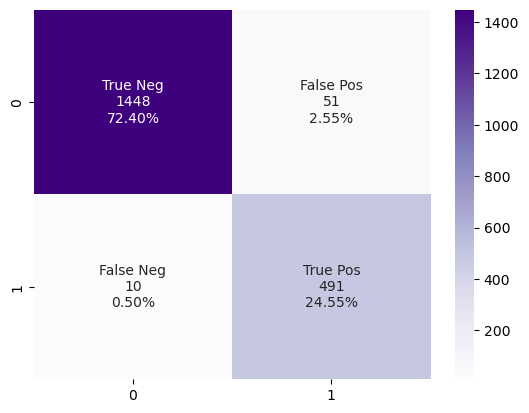

In [56]:
nb_model = nb_search.best_estimator_
nb_model.fit(X,Y)
nb_predicted = nb_model.predict(X_valid)
nb_matrix = confusion_matrix(y_valid, nb_predicted) 
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in nb_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in nb_matrix.flatten()/np.sum(nb_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(nb_matrix, annot=labels, fmt='', cmap='Purples')

In [57]:
#classification report
nb_report = classification_report(y_valid, nb_predicted) 
print(nb_report)

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      1499
         1.0       0.91      0.98      0.94       501

    accuracy                           0.97      2000
   macro avg       0.95      0.97      0.96      2000
weighted avg       0.97      0.97      0.97      2000



### LSVC Further Evaluation

In [58]:
print(scoring_cv('accuracy',lsvc_search.best_estimator_))
print(scoring_cv('neg_log_loss',lsvc_search.best_estimator_))
print(scoring_cv('roc_auc',lsvc_search.best_estimator_))

('accuracy', 0.99437, 0.00213)
('neg_log_loss', nan, nan)
('roc_auc', 0.99993, 3e-05)


AUC: 1.000


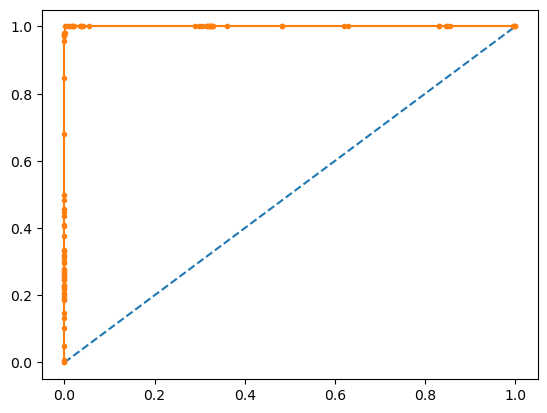

In [59]:
# Fit the LSVC model
lsvc_model = lsvc_search.best_estimator_
lsvc_model.fit(X, Y)
# Predict probabilities
probs_lsvc = lsvc_model.decision_function(X_valid)
# Calculate AUC
auc_lsvc = roc_auc_score(y_valid, probs_lsvc)
print('AUC: %.3f' % auc_lsvc)
# Calculate ROC curve
fpr_lsvc, tpr_lsvc, thresholds_lsvc = roc_curve(y_valid, probs_lsvc)
# Plot the ROC curve for the model
pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot(fpr_lsvc, tpr_lsvc, marker='.')
pyplot.show()

<Axes: >

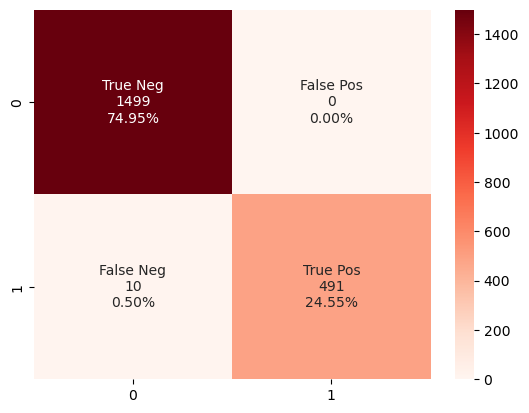

In [60]:
lsvc_predicted = lsvc_model.predict(X_valid)
lsvc_matrix = confusion_matrix(y_valid, lsvc_predicted) 
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in lsvc_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in lsvc_matrix.flatten()/np.sum(lsvc_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(lsvc_matrix, annot=labels, fmt='', cmap='Reds')

In [61]:
#classification report
lsvc_report = classification_report(y_valid, lsvc_predicted) 
print(lsvc_report)

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      1499
         1.0       1.00      0.98      0.99       501

    accuracy                           0.99      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      0.99      0.99      2000



### KNN Further Evaluation

In [62]:
print(scoring_cv('accuracy', knn_search.best_estimator_))
print(scoring_cv('neg_log_loss', knn_search.best_estimator_))
print(scoring_cv('roc_auc', knn_search.best_estimator_))

('accuracy', 0.99988, 0.00025)
('neg_log_loss', -0.00451, 0.00901)
('roc_auc', 0.99992, 0.00017)


AUC: 1.000


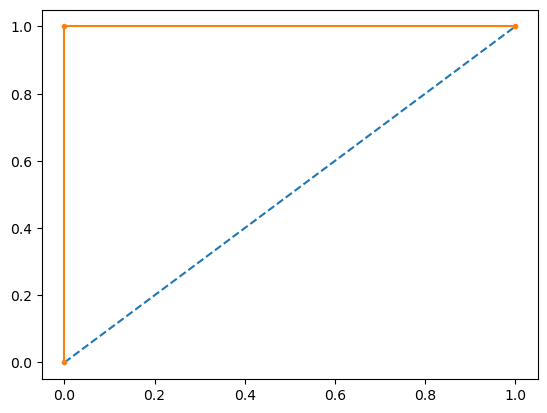

In [63]:
# Fit the KNN model
knn_model = knn_search.best_estimator_
knn_model.fit(X, Y)
# Predict probabilities
probs_knn = knn_model.predict(X_valid)
# Calculate AUC
auc_knn = roc_auc_score(y_valid, probs_knn)
print('AUC: %.3f' % auc_knn)
# Calculate ROC curve
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_valid, probs_knn)
# Plot the ROC curve for the model
pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot(fpr_knn, tpr_knn, marker='.')
pyplot.show()

<Axes: >

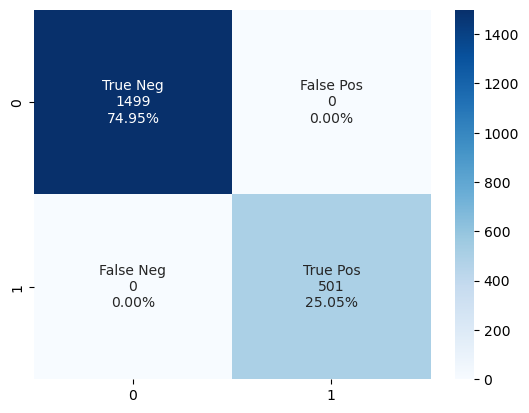

In [64]:
# Predict using the best KNN model
knn_predicted = knn_model.predict(X_valid)
knn_matrix = confusion_matrix(y_valid, knn_predicted)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in knn_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in knn_matrix.flatten()/np.sum(knn_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(knn_matrix, annot=labels, fmt='', cmap='Blues')

In [65]:
#classification report for KNN
knn_report = classification_report(y_valid, knn_predicted)
print(knn_report)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1499
         1.0       1.00      1.00      1.00       501

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



### LDA Further Evaluation


In [66]:
print(scoring_cv('accuracy', lda_search.best_estimator_))
print(scoring_cv('neg_log_loss', lda_search.best_estimator_))
print(scoring_cv('roc_auc', lda_search.best_estimator_))

('accuracy', 0.99437, 0.00213)
('neg_log_loss', -0.20276, 0.07671)
('roc_auc', 0.99978, 0.00012)


AUC: 1.000


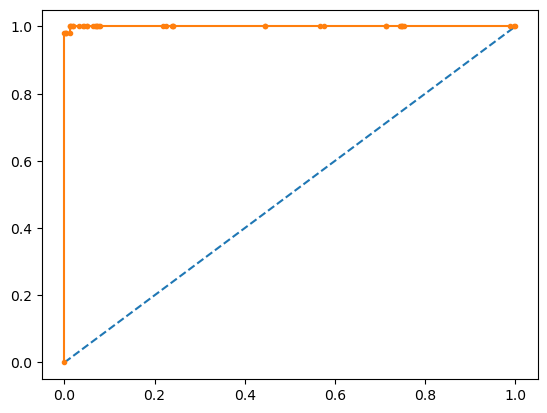

In [67]:
# Fit the LDA model
lda_model = lda_search.best_estimator_
lda_model.fit(X, Y)
# Predict probabilities
probs_lda = lda_model.predict_proba(X_valid)
probs_lda = probs_lda[:, 1]
# Calculate AUC
auc_lda = roc_auc_score(y_valid, probs_lda)
print('AUC: %.3f' % auc_lda)
# Calculate ROC curve
fpr_lda, tpr_lda, thresholds_lda = roc_curve(y_valid, probs_lda)
# Plot the ROC curve for the model
pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot(fpr_lda, tpr_lda, marker='.')
pyplot.show()

<Axes: >

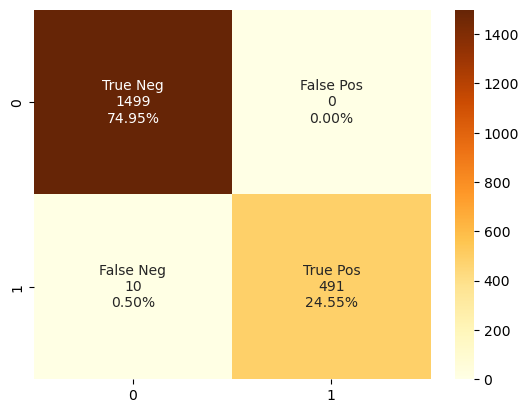

In [68]:
# Predict using the LDA model
lda_predicted = lda_model.predict(X_valid)
lda_matrix = confusion_matrix(y_valid, lda_predicted)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in lda_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in lda_matrix.flatten()/np.sum(lda_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(lda_matrix.shape)
sns.heatmap(lda_matrix, annot=labels, fmt='', cmap='YlOrBr')


In [69]:
# Generate classification report for KNN
lda_report = classification_report(y_valid, lda_predicted)
print(lda_report)

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      1499
         1.0       1.00      0.98      0.99       501

    accuracy                           0.99      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      0.99      0.99      2000



#### All models perform well on the validation set 

## Apply Models to the Test Data

In [70]:
testfile = 'testing_data.csv'

In [71]:
test = pd.read_csv(testfile)
test_data=test
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Columns: 152 entries, 0 to 0.113
dtypes: float64(4), int64(148)
memory usage: 3.5 MB


In [72]:
array = test_data.values
x_test = array[ : , 0:151]
y_test = array[ : , 151]
x_test.shape

(3000, 151)

In [73]:
# Normalise test data 
n_X_test = norm_scaler.transform(x_test)

# Predict with encoder
X_test = encoded.predict(n_X_test)

# Scale encoder output
X_test = norm_scaler20.transform(X_test)

# Add 20 features from encoder output to normalised full dataset
X_test_full = pd.DataFrame(n_X_test)
X_test_gen = pd.DataFrame(X_test)
X_test_df = pd.concat([X_test_full,X_test_gen],axis = 1)

# Feature selection 1 - variance threshold
X_test = feat_sel.transform(X_test_df)

# Feature selection 2 - Kbest with chi2 filter
X_test = kbest.transform(X_test)

# Feature selection 2 - Kbest with MI filter
X_test = kbest_mi.transform(X_test)

X_test.shape

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


(3000, 15)

### Logistic Regression

In [74]:
lr_pred = lr_model.predict(X_test)
lr_score = lr_model.score(X_test, y_test)
lr_score

0.9963333333333333

AUC: 1.000


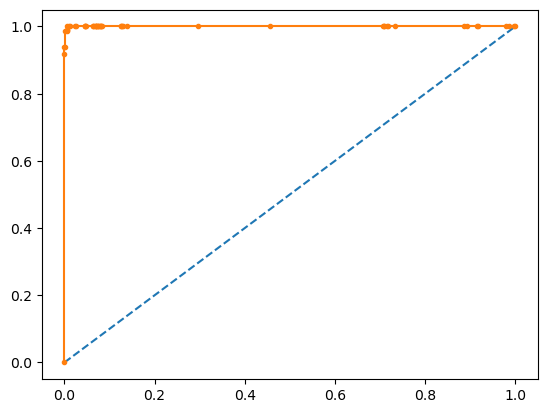

In [75]:
lr_probs = lr_model.predict_proba(X_test)
probs = lr_probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot the roc curve for the model
pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot(fpr, tpr, marker='.')
pyplot.show()

<Axes: >

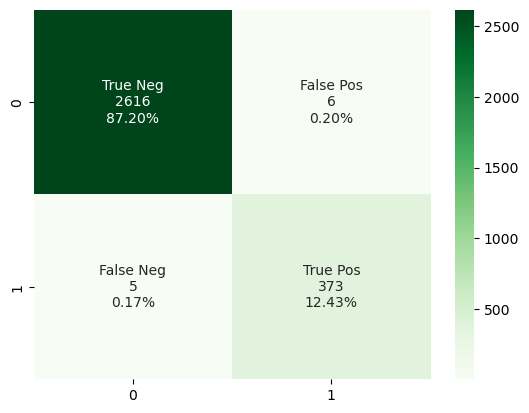

In [76]:
lr_matrix = confusion_matrix(y_test, lr_pred) 
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in lr_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in lr_matrix.flatten()/np.sum(lr_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(lr_matrix, annot=labels, fmt='', cmap='Greens')

In [77]:
#classification report
lr_report = classification_report(y_test, lr_pred) 
print(lr_report)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2622
         1.0       0.98      0.99      0.99       378

    accuracy                           1.00      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       1.00      1.00      1.00      3000



### Naive Bayes

In [78]:
nb_pred = nb_model.predict(X_test)
nb_score = nb_model.score(X_test, y_test)
nb_score

0.9503333333333334

AUC: 0.997


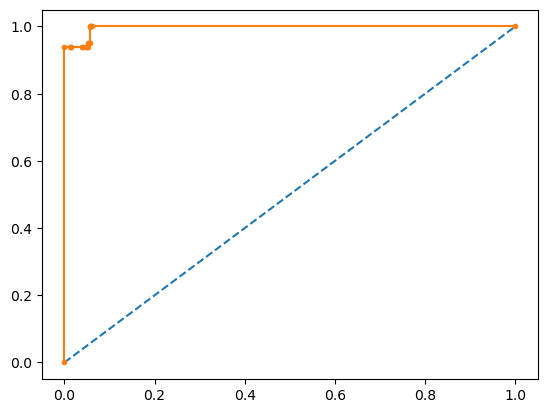

In [79]:
nb_probs =nb_model.predict_proba(X_test)
probs = nb_probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot the roc curve for the model
pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot(fpr, tpr, marker='.')
pyplot.show()

<Axes: >

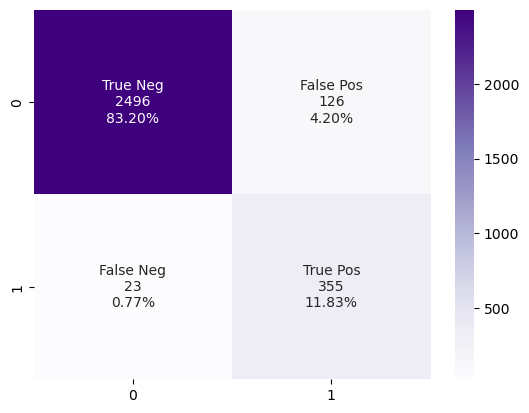

In [80]:
nb_matrix = confusion_matrix(y_test, nb_pred) 
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in nb_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in nb_matrix.flatten()/np.sum(nb_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(nb_matrix, annot=labels, fmt='', cmap='Purples')

In [81]:
#classification report
nb_report = classification_report(y_test, nb_pred) 
print(nb_report)

              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97      2622
         1.0       0.74      0.94      0.83       378

    accuracy                           0.95      3000
   macro avg       0.86      0.95      0.90      3000
weighted avg       0.96      0.95      0.95      3000



### Linear SVC

In [82]:
lsvc_pred = lsvc_model.predict(X_test)
lsvc_score = lsvc_model.score(X_test, y_test)
lsvc_score

0.9923333333333333

AUC: 1.000


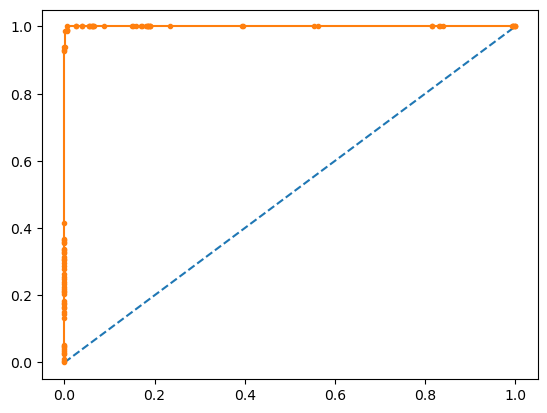

In [83]:
# Predict probabilities using the LSVC model
lsvc_probs = lsvc_model.decision_function(X_test)
probs_lsvc = lsvc_probs
# Calculate AUC
auc_lsvc = roc_auc_score(y_test, probs_lsvc)
print('AUC: %.3f' % auc_lsvc)
# Calculate ROC curve
fpr_lsvc, tpr_lsvc, thresholds_lsvc = roc_curve(y_test, probs_lsvc)
# Plot the ROC curve for the model
pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot(fpr_lsvc, tpr_lsvc, marker='.')
pyplot.show()

<Axes: >

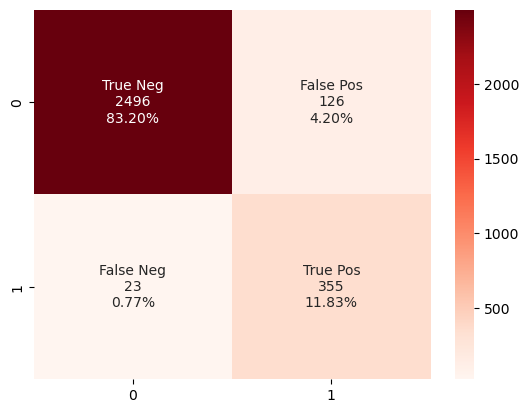

In [84]:
lsvc_matrix = confusion_matrix(y_test, nb_pred) 
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in lsvc_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in lsvc_matrix.flatten()/np.sum(lsvc_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(lsvc_matrix, annot=labels, fmt='', cmap='Reds')

In [85]:
#classification report
lsvc_report = classification_report(y_test, lsvc_pred) 
print(lsvc_report)

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      2622
         1.0       1.00      0.94      0.97       378

    accuracy                           0.99      3000
   macro avg       1.00      0.97      0.98      3000
weighted avg       0.99      0.99      0.99      3000



### KNN

In [86]:
knn_pred = knn_model.predict(X_test)
knn_score = knn_model.score(X_test, y_test)
knn_score

1.0

AUC: 1.000


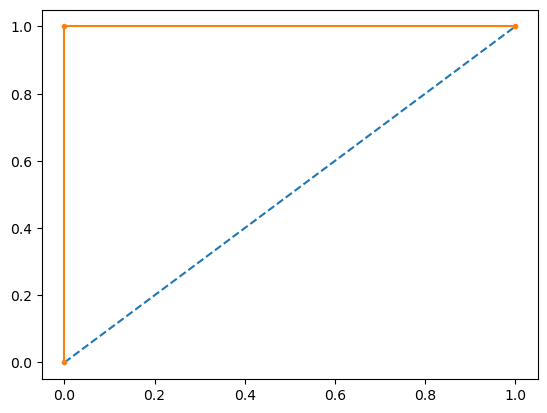

In [87]:
# Predict probabilities using the KNN model
knn_probs = knn_model.predict_proba(X_test)
probs_knn = knn_probs[:, 1]
# Calculate AUC
auc_knn = roc_auc_score(y_test, probs_knn)
print('AUC: %.3f' % auc_knn)
# Calculate ROC curve
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, probs_knn)
# Plot the ROC curve for the model
pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot(fpr_knn, tpr_knn, marker='.')
pyplot.show()

<Axes: >

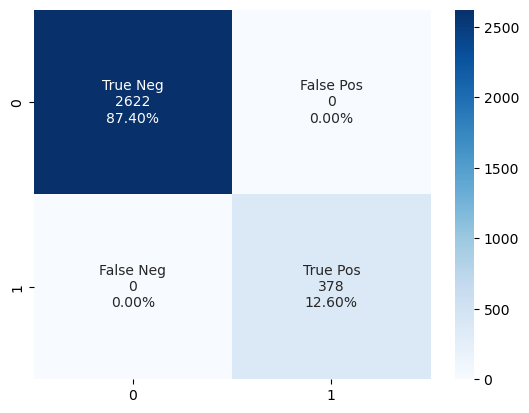

In [88]:
knn_matrix = confusion_matrix(y_test, knn_pred)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in knn_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in knn_matrix.flatten()/np.sum(knn_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(knn_matrix, annot=labels, fmt='', cmap='Blues')

In [89]:
#classification report
knn_report = classification_report(y_test, knn_pred) 
print(knn_report)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2622
         1.0       1.00      1.00      1.00       378

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



### LDA

In [90]:
lda_pred = lda_model.predict(X_test)
lda_score = lda_model.score(X_test, y_test)
lda_score

0.9923333333333333

AUC: 0.999


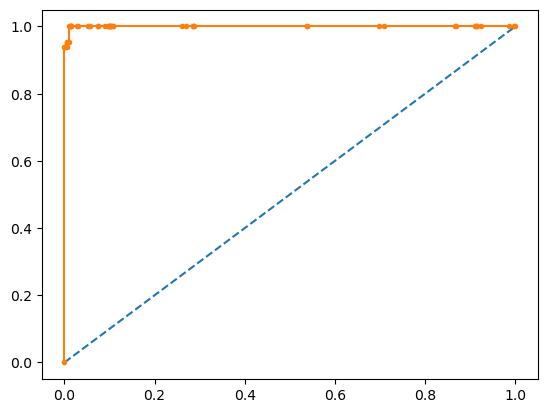

In [91]:
# Predict probabilities using the LDA model
lda_probs = lda_model.predict_proba(X_test)
probs_lda = lda_probs[:, 1]
# Calculate AUC
auc_lda = roc_auc_score(y_test, probs_lda)
print('AUC: %.3f' % auc_lda)
# Calculate ROC curve
fpr_lda, tpr_lda, thresholds_lda = roc_curve(y_test, probs_lda)
# Plot the ROC curve for the model
pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot(fpr_lda, tpr_lda, marker='.')
pyplot.show()

<Axes: >

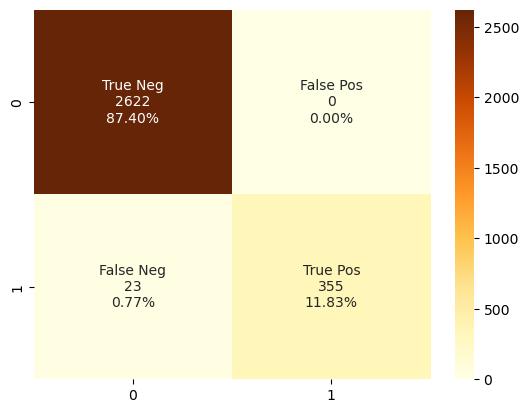

In [92]:
lda_matrix = confusion_matrix(y_test, lda_pred)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in lda_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in lda_matrix.flatten()/np.sum(lda_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(lda_matrix, annot=labels, fmt='', cmap='YlOrBr')

In [93]:
#classification report
lda_report = classification_report(y_test, lda_pred) 
print(lda_report)

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      2622
         1.0       1.00      0.94      0.97       378

    accuracy                           0.99      3000
   macro avg       1.00      0.97      0.98      3000
weighted avg       0.99      0.99      0.99      3000



### END OF PROJECT!